In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## **1. Generación de datos clínicos simulados con valores faltantes**

Crearemos un dataset que simula señales vitales de pacientes con patrones realistas de valores faltantes.

In [ ]:
# Generar datos temporales para 3 pacientes
np.random.seed(42)

# Crear timestamps cada 1 minuto durante 2 horas
start_time = datetime(2025, 1, 1, 8, 0, 0)
timestamps = [start_time + timedelta(minutes=i) for i in range(120)]

# Crear datos para 3 pacientes
data = []
for patient_id in [101, 102, 103]:
    for ts in timestamps:
        data.append({
            'patient_id': patient_id,
            'timestamp': ts,
            'HR': np.random.normal(75 + patient_id % 10, 8),  # Heart Rate
            'SBP': np.random.normal(120 + patient_id % 10, 10),  # Systolic Blood Pressure
            'DBP': np.random.normal(80 + patient_id % 5, 7),  # Diastolic Blood Pressure
            'SpO2': np.random.normal(97, 1.5)  # Oxygen Saturation
        })

df = pd.DataFrame(data)

# Redondear valores a formato realista
df['HR'] = df['HR'].round(0)
df['SBP'] = df['SBP'].round(0)
df['DBP'] = df['DBP'].round(0)
df['SpO2'] = df['SpO2'].round(1)

print(f"Dataset original: {df.shape}")
df.head(10)

Dataset original: (360, 6)


,patient_id,timestamp,HR,SBP,DBP,SpO2
0,101,2025-01-01 08:00:00,80.0,120.0,86.0,99.3
1,101,2025-01-01 08:01:00,74.0,119.0,92.0,98.2
2,101,2025-01-01 08:02:00,72.0,126.0,78.0,96.3
3,101,2025-01-01 08:03:00,78.0,102.0,69.0,96.2
4,101,2025-01-01 08:04:00,68.0,124.0,75.0,94.9
5,101,2025-01-01 08:05:00,88.0,119.0,81.0,94.9
6,101,2025-01-01 08:06:00,72.0,122.0,73.0,97.6
7,101,2025-01-01 08:07:00,71.0,118.0,77.0,99.8
8,101,2025-01-01 08:08:00,76.0,110.0,87.0,95.2
9,101,2025-01-01 08:09:00,78.0,101.0,72.0,97.3


## **2. Introducir valores faltantes de forma NO aleatoria**

Los valores faltantes en datos clínicos suelen aparecer por:
- Desconexión de sensores
- Procedimientos médicos
- Fallas en equipos
- Movimiento del paciente

In [ ]:
# Crear una copia para introducir valores faltantes
df_missing = df.copy()

# Patrón 1: Vacío de 7 minutos en HR para paciente 101 (desconexión de sensor)
mask_hr = (df_missing['patient_id'] == 101) & \
          (df_missing['timestamp'] >= datetime(2025, 1, 1, 8, 30, 0)) & \
          (df_missing['timestamp'] < datetime(2025, 1, 1, 8, 37, 0))
df_missing.loc[mask_hr, 'HR'] = np.nan

# Patrón 2: Valores esporádicos faltantes en SBP/DBP (fallas en medición)
random_missing = np.random.choice(df_missing.index, size=30, replace=False)
df_missing.loc[random_missing, ['SBP', 'DBP']] = np.nan

# Patrón 3: Período largo sin SpO2 para paciente 102 (procedimiento)
mask_spo2 = (df_missing['patient_id'] == 102) & \
            (df_missing['timestamp'] >= datetime(2025, 1, 1, 9, 0, 0)) & \
            (df_missing['timestamp'] < datetime(2025, 1, 1, 9, 20, 0))
df_missing.loc[mask_spo2, 'SpO2'] = np.nan

print("\n=== Análisis de valores faltantes ===")
print(f"\nTotal de registros: {len(df_missing)}")
print(f"\nValores faltantes por columna:")
print(df_missing.isnull().sum())
print(f"\nPorcentaje de valores faltantes:")
print((df_missing.isnull().sum() / len(df_missing) * 100).round(2))


=== Análisis de valores faltantes ===

Total de registros: 360

Valores faltantes por columna:
patient_id     0
timestamp      0
HR             7
SBP           30
DBP           30
SpO2          20
dtype: int64

Porcentaje de valores faltantes:
patient_id    0.00
timestamp     0.00
HR            1.94
SBP           8.33
DBP           8.33
SpO2          5.56
dtype: float64


## **3. Análisis inicial: Primera columna con valores faltantes**

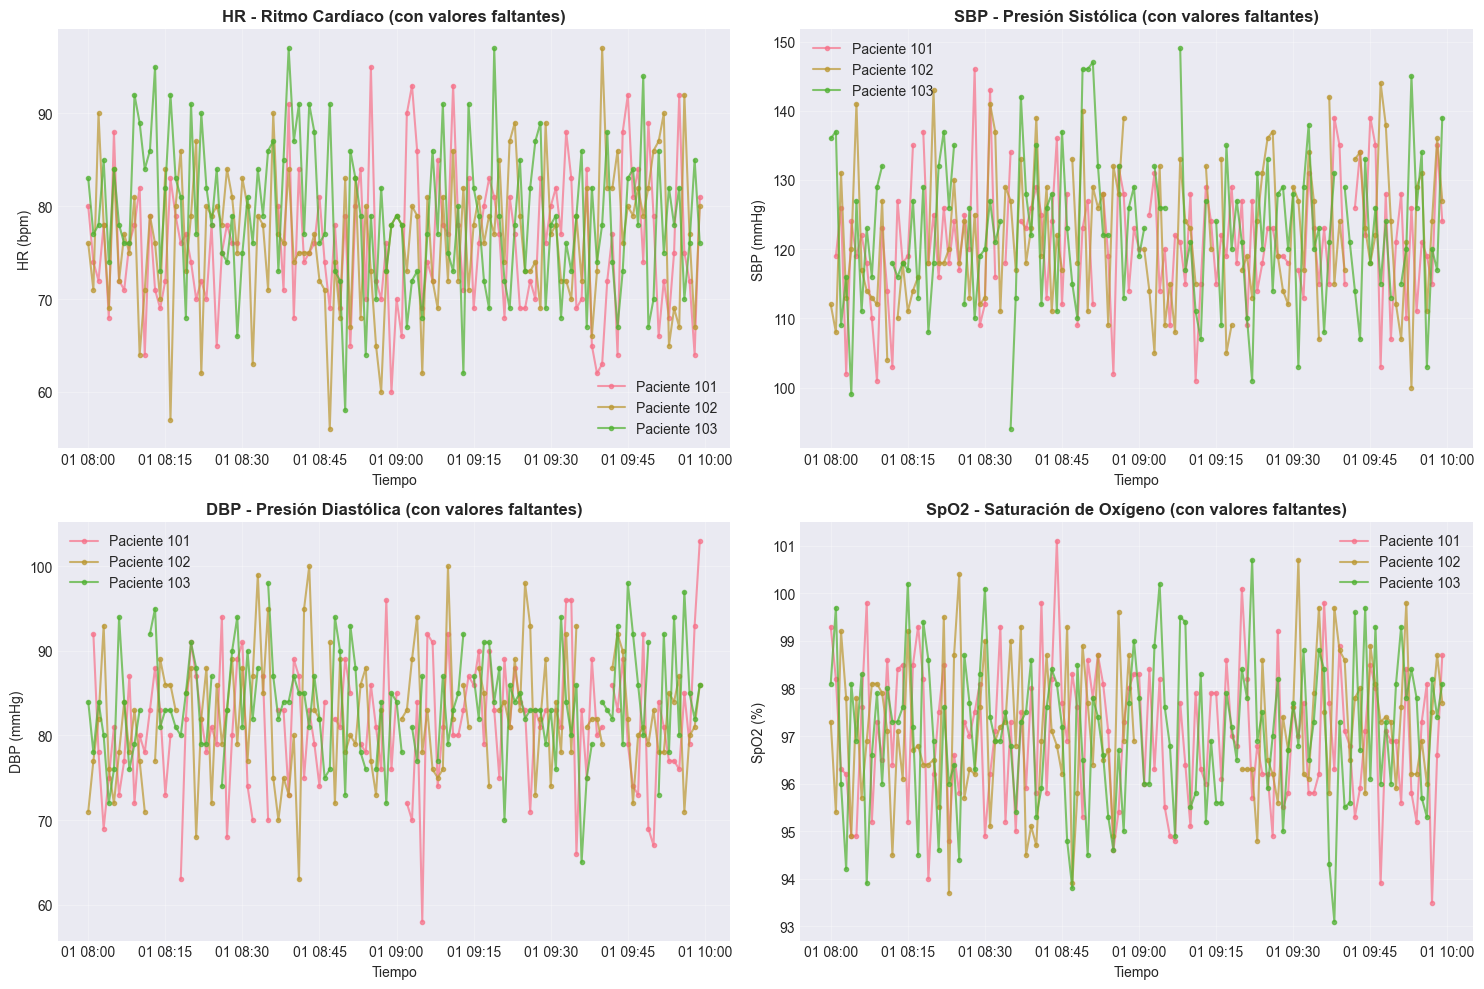

In [ ]:
# Visualizar patrones de valores faltantes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# HR con valores faltantes
for patient in df_missing['patient_id'].unique():
    patient_data = df_missing[df_missing['patient_id'] == patient]
    axes[0, 0].plot(patient_data['timestamp'], patient_data['HR'], 
                    marker='o', markersize=3, label=f'Paciente {patient}', alpha=0.7)
axes[0, 0].set_title('HR - Ritmo Cardíaco (con valores faltantes)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Tiempo')
axes[0, 0].set_ylabel('HR (bpm)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# SBP con valores faltantes
for patient in df_missing['patient_id'].unique():
    patient_data = df_missing[df_missing['patient_id'] == patient]
    axes[0, 1].plot(patient_data['timestamp'], patient_data['SBP'], 
                    marker='o', markersize=3, label=f'Paciente {patient}', alpha=0.7)
axes[0, 1].set_title('SBP - Presión Sistólica (con valores faltantes)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Tiempo')
axes[0, 1].set_ylabel('SBP (mmHg)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# DBP con valores faltantes
for patient in df_missing['patient_id'].unique():
    patient_data = df_missing[df_missing['patient_id'] == patient]
    axes[1, 0].plot(patient_data['timestamp'], patient_data['DBP'], 
                    marker='o', markersize=3, label=f'Paciente {patient}', alpha=0.7)
axes[1, 0].set_title('DBP - Presión Diastólica (con valores faltantes)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Tiempo')
axes[1, 0].set_ylabel('DBP (mmHg)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# SpO2 con valores faltantes
for patient in df_missing['patient_id'].unique():
    patient_data = df_missing[df_missing['patient_id'] == patient]
    axes[1, 1].plot(patient_data['timestamp'], patient_data['SpO2'], 
                    marker='o', markersize=3, label=f'Paciente {patient}', alpha=0.7)
axes[1, 1].set_title('SpO2 - Saturación de Oxígeno (con valores faltantes)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tiempo')
axes[1, 1].set_ylabel('SpO2 (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **4. Técnica 1: Forward Fill (ffill) por paciente**

**Forward Fill:** Propaga el último valor válido hacia adelante.

**Cuándo usar:**
- Valores estables que cambian lentamente (temperatura, peso)
- Vacíos cortos (< 5 minutos)
- Variables categóricas o estados

In [ ]:
# Aplicar forward fill por paciente
df_ffill = df_missing.copy()
df_ffill[['HR', 'SBP', 'DBP', 'SpO2']] = df_ffill.groupby('patient_id')[['HR', 'SBP', 'DBP', 'SpO2']].ffill()

print("\n=== Después de Forward Fill ===")
print(f"Valores faltantes restantes:")
print(df_ffill.isnull().sum())


=== Después de Forward Fill ===
Valores faltantes restantes:
patient_id    0
timestamp     0
HR            0
SBP           1
DBP           1
SpO2          0
dtype: int64


## **5. Técnica 2: Backward Fill (bfill) por paciente**

**Backward Fill:** Propaga el siguiente valor válido hacia atrás.

**Cuándo usar:**
- Valores al inicio de la serie
- Combinado con ffill para valores extremos

In [ ]:
# Aplicar backward fill para valores iniciales
df_bfill = df_ffill.copy()
df_bfill[['HR', 'SBP', 'DBP', 'SpO2']] = df_bfill.groupby('patient_id')[['HR', 'SBP', 'DBP', 'SpO2']].bfill()

print("\n=== Después de Backward Fill ===")
print(f"Valores faltantes restantes:")
print(df_bfill.isnull().sum())


=== Después de Backward Fill ===
Valores faltantes restantes:
patient_id    0
timestamp     0
HR            0
SBP           0
DBP           0
SpO2          0
dtype: int64


## **6. Técnica 3: Interpolación Lineal**

**Interpolación Lineal:** Conecta puntos con líneas rectas.

**Diferencia con Forward Fill (Quiz 2):**
- **Forward fill:** Mantiene constante el último valor (línea horizontal)
- **Interpolación lineal:** Crea una transición suave entre valores conocidos (línea diagonal)

**Cuándo usar:**
- Variables continuas que cambian gradualmente (HR, temperatura)
- Vacíos cortos a medianos (< 10 minutos)
- Cuando se espera tendencia gradual

In [ ]:
# Aplicar interpolación lineal por paciente
df_linear = df_missing.copy()
df_linear[['HR', 'SBP', 'DBP', 'SpO2']] = df_linear.groupby('patient_id')[['HR', 'SBP', 'DBP', 'SpO2']].transform(
    lambda x: x.interpolate(method='linear')
)

print("\n=== Después de Interpolación Lineal ===")
print(f"Valores faltantes restantes:")
print(df_linear.isnull().sum())


=== Después de Interpolación Lineal ===
Valores faltantes restantes:
patient_id    0
timestamp     0
HR            0
SBP           1
DBP           1
SpO2          0
dtype: int64


## **7. Técnica 4: Interpolación Polinómica**

**Interpolación Polinómica:** Ajusta curvas suaves (no lineales).

**Cuándo usar:**
- Variables con cambios no lineales (SpO2 durante episodios)
- Curvas con aceleración/desaceleración
- Vacíos medianos con contexto suficiente

In [ ]:
df_poly = df_missing.copy()

def _poly_safe(series, order=2):
    if series.dropna().shape[0] >= (order + 1):
        try:
            return series.interpolate(method='polynomial', order=order)
        except Exception:
            # fallback seguro a interpolación lineal si algo falla
            return series.interpolate(method='linear')
    else:
        # insuficientes puntos para polinomio: usar lineal (o devolver tal cual)
        return series.interpolate(method='linear')

df_poly[['HR', 'SBP', 'DBP', 'SpO2']] = df_poly.groupby('patient_id')[['HR', 'SBP', 'DBP', 'SpO2']].transform(
    lambda col: _poly_safe(col, order=2)
)

print("\n=== Después de Interpolación Polinómica (segura) ===")
print(f"Valores faltantes restantes:")
print(df_poly.isnull().sum())


=== Después de Interpolación Polinómica (segura) ===
Valores faltantes restantes:
patient_id    0
timestamp     0
HR            0
SBP           1
DBP           1
SpO2          0
dtype: int64


## **8. Técnica 5: Interpolación por Tiempo**

**Interpolación por Tiempo:** Considera el espaciado temporal real entre mediciones.

**Cuándo usar:**
- Mediciones con intervalos irregulares
- Datos con timestamp preciso
- Cuando el tiempo es crítico para la interpretación

In [ ]:
# Aplicar interpolación por tiempo
df_time = df_missing.copy()
df_time = df_time.set_index('timestamp')

# Interpolación por tiempo para cada paciente
df_time_interp = df_time.groupby('patient_id')[['HR', 'SBP', 'DBP', 'SpO2']].apply(
    lambda group: group.interpolate(method='time')
)

df_time = df_time_interp.reset_index()

print("\n=== Después de Interpolación por Tiempo ===")
print(f"Valores faltantes restantes:")
print(df_time.isnull().sum())


=== Después de Interpolación por Tiempo ===
Valores faltantes restantes:
patient_id    0
timestamp     0
HR            0
SBP           1
DBP           1
SpO2          0
dtype: int64


## **9. Guía de decisión: ¿Qué técnica usar según el tipo de variable?**

In [ ]:
# Crear tabla de recomendaciones
recomendaciones = pd.DataFrame({
    'Variable': ['HR (Ritmo Cardíaco)', 'SBP (Presión Sistólica)', 'DBP (Presión Diastólica)', 'SpO2 (Saturación O2)'],
    'Vacío Corto (<5 min)': ['Forward Fill o Lineal', 'Lineal', 'Lineal', 'Forward Fill'],
    'Vacío Mediano (5-15 min)': ['Lineal', 'Lineal o Polinómica', 'Lineal', 'Lineal'],
    'Vacío Largo (>15 min)': ['NO IMPUTAR', 'NO IMPUTAR', 'NO IMPUTAR', 'NO IMPUTAR'],
    'Razón': [
        'Cambia gradualmente, riesgo de artefactos en vacíos largos',
        'Variable crítica, evitar imputación errónea en períodos largos',
        'Correlacionada con SBP, misma precaución',
        'Puede cambiar abruptamente, vacíos largos son sospechosos'
    ]
})

print("\n" + "="*100)
print("GUÍA DE DECISIÓN: Técnicas de imputación por variable y duración del vacío")
print("="*100)
print(recomendaciones.to_string(index=False))
print("="*100)


GUÍA DE DECISIÓN: Técnicas de imputación por variable y duración del vacío
                Variable  Vacío Corto (<5 min) Vacío Mediano (5-15 min) Vacío Largo (>15 min)                                                          Razón
     HR (Ritmo Cardíaco) Forward Fill o Lineal                   Lineal            NO IMPUTAR     Cambia gradualmente, riesgo de artefactos en vacíos largos
 SBP (Presión Sistólica)                Lineal      Lineal o Polinómica            NO IMPUTAR Variable crítica, evitar imputación errónea en períodos largos
DBP (Presión Diastólica)                Lineal                   Lineal            NO IMPUTAR                       Correlacionada con SBP, misma precaución
    SpO2 (Saturación O2)          Forward Fill                   Lineal            NO IMPUTAR      Puede cambiar abruptamente, vacíos largos son sospechosos


## **10. Advertencias sobre imputación inapropiada**

### **⚠️ PELIGROS DE LA IMPUTACIÓN INCORRECTA:**

1. **Crear señales falsas:**
   - Imputar durante eventos críticos puede ocultar emergencias
   - Ejemplo: Interpolar HR durante paro cardíaco

2. **Suavizar variabilidad importante:**
   - La variabilidad de HR es un indicador clínico
   - Interpolación excesiva puede eliminar información diagnóstica

3. **Introducir tendencias artificiales:**
   - Interpolación polinómica puede crear oscilaciones no reales
   - Forward fill mantiene valores que pueden ser obsoletos

4. **Ignorar el contexto clínico:**
   - Vacíos durante cirugía, traslados o procedimientos NO deben imputarse
   - Consultar con expertos clínicos

### **✅ BUENAS PRÁCTICAS:**

- Documentar TODAS las imputaciones realizadas
- Mantener columnas originales sin modificar
- Crear flags indicando qué valores fueron imputados
- Validar con expertos clínicos
- Considerar análisis de sensibilidad (con y sin imputación)